<a href="https://colab.research.google.com/github/jose-cano/DataScience-Projects/blob/main/Facebook_stocks_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Facebook stock price from 2018
The goal of this project is to uncover and explore trends in the data and explain those trends.

**Why data from 2018?**

The year 2018 marked a difficult time for Facebook, and I would like to explore how this was reflected in the data.

In [ ]:
%pip install yfinance

In [49]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Extracting data from yFinance
The yFinance package provides an easy way to get data in a clean format.

In [19]:
fb = yf.download("FB", start="2018-01-01", end="2018-12-31")

[*********************100%***********************]  1 of 1 completed


# Finding outliers
An outlier is an observation that lies well outside of the norm (extreme value). Statistician disagree on the exact definition, but a rule of thumb is that these values are three standard deviations away from the mean. Let's create a column with Z-score for the volumes traded in Facebook stock and find observations with Z-score greater than three in absolute value. A Z-Score is calculated by subtracting the mean from the observation, and then dividing by the standard deviation.

In [33]:
fb.assign(
    abs_z_score_volume=lambda x: x.Volume.sub(x.Volume.mean()).div(x.Volume.std()).abs(),
    day_of_week=lambda x: x.index.day_name()
).query('abs_z_score_volume > 3')

,Open,High,Low,Close,Adj Close,Volume,abs_z_score_volume,day_of_week
Date,,,,,,,,
2018-03-19,177.009995,177.169998,170.059998,172.559998,172.559998,88140100,3.147310,Monday
2018-03-20,167.470001,170.199997,161.949997,168.149994,168.149994,129851800,5.318321,Tuesday
2018-03-21,164.800003,173.399994,163.300003,169.389999,169.389999,106598800,4.108048,Wednesday
2018-03-26,160.820007,161.100006,149.020004,160.059998,160.059998,126116600,5.123911,Monday
2018-07-26,174.889999,180.130005,173.750000,176.259995,176.259995,169803700,7.397737,Thursday


In [30]:
fb['2018-07-25':'2018-07-26']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-25,215.720001,218.619995,214.270004,217.500000,217.500000,58954200
2018-07-26,174.889999,180.130005,173.750000,176.259995,176.259995,169803700


July 26, 2018 marks the highest volume traded for the year. On July 25, 2018 Facebook announced that the company missed projections on key metrics after struggling with data leaks and fake news scandals. The news was followed by after-hours selling and when the market reopened the next morning, the stock had dropped from \$217.50 at close on the 25th to \$174.89 at 
market open on the 26th. All of this resulted in a loss of about $120 billion.

https://www.marketwatch.com/story/facebook-stock-crushed-after-revenue-user-growth-miss-2018-07-25

Let's also explore which days had the largest percentage change in volume traded relative to the day prior. We might want to explore those dates to see if something happened that prompted such a change.

In [32]:
fb.assign(
    volume_pct_change=fb.Volume.pct_change(),
    pct_change_rank=lambda x: x.volume_pct_change.abs().rank(ascending=False),
    day_of_week=lambda x: x.index.day_name()
).nsmallest(5, 'pct_change_rank')

,Open,High,Low,Close,Adj Close,Volume,volume_pct_change,pct_change_rank,day_of_week
Date,,,,,,,,,
2018-01-12,178.059998,181.479996,177.399994,179.369995,179.369995,77551300,7.087865,1.0,Friday
2018-03-19,177.009995,177.169998,170.059998,172.559998,172.559998,88140100,2.611796,2.0,Monday
2018-07-26,174.889999,180.130005,173.750000,176.259995,176.259995,169803700,1.880265,3.0,Thursday
2018-09-21,166.639999,167.250000,162.809998,162.929993,162.929993,45994800,1.428961,4.0,Friday
2018-03-26,160.820007,161.100006,149.020004,160.059998,160.059998,126116600,1.352496,5.0,Monday


In [26]:
 fb['2018-01-11':'2018-01-12']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-11,188.399994,188.399994,187.380005,187.770004,187.770004,9588600
2018-01-12,178.059998,181.479996,177.399994,179.369995,179.369995,77551300


The number 1 ranked day for percentage change in volume traded is January 12, 2018. This happened when Facebook announced changes to the news feed to prioritize content from a users friends over brands they follow. Because a large amount of Facebooks revenue comes from advertising, many people decided to sell stocks and this increades the volume traded.

https://www.cnbc.com/2018/11/20/facebooks-scandals-in-2018-effect-on-stock.html

https://www.investopedia.com/ask/answers/120114/how-does-facebook-fb-make-money.asp

In [40]:
fb['2018-03-16':'2018-03-29'].assign(
    day_of_week=lambda x: x.index.day_name()
)

,Open,High,Low,Close,Adj Close,Volume,day_of_week
Date,,,,,,,
2018-03-16,184.490005,185.330002,183.410004,185.089996,185.089996,24403400,Friday
2018-03-19,177.009995,177.169998,170.059998,172.559998,172.559998,88140100,Monday
2018-03-20,167.470001,170.199997,161.949997,168.149994,168.149994,129851800,Tuesday
2018-03-21,164.800003,173.399994,163.300003,169.389999,169.389999,106598800,Wednesday
2018-03-22,166.130005,170.270004,163.720001,164.889999,164.889999,73743000,Thursday
2018-03-23,165.440002,166.600006,159.020004,159.389999,159.389999,53609700,Friday
2018-03-26,160.820007,161.100006,149.020004,160.059998,160.059998,126116600,Monday
2018-03-27,156.309998,162.850006,150.750000,152.220001,152.220001,79117000,Tuesday
2018-03-28,151.649994,155.880005,150.800003,153.029999,153.029999,60029200,Wednesday


The Cambridge Analytica political data privacy issue happened on Saturday, 
March 17, 2018. Trading with this information began Monday 19th. Then in March 26, the FTC began an investigation into the Cambridge Analytica situation.

https://www.nytimes.com/2018/03/19/technology/facebook-cambridge-analytica-explained.html

https://www.cnbc.com/2018/03/26/ftc-confirms-facebook-data-breach-investigation.html

# Binning
If we are interested in seeing the days that had high volume of trade, categorizing the values of volume traded into bins can be more convenient than working with the distinct values. We can see that in the data, no two days had the same volume traded (shown below). If we created equally spaced bins, the days that had large trading volume would cause the bin width to be large, causing an imbalance of days per bin. Creating bins based on quantiles might be better for this situation.

In [28]:
(fb.Volume.value_counts() > 1).sum()

0

In [43]:
volume_qbins = pd.qcut(
    fb.Volume, q=4, labels=["q1", "q2", "q3", "q4"]
)
volume_qbins.value_counts()

q4    63
q1    63
q3    62
q2    62
Name: Volume, dtype: int64

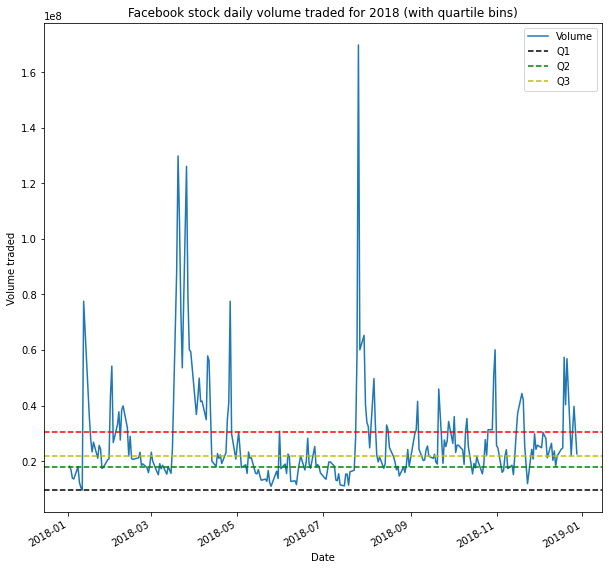

In [108]:
fb['quartile'] = pd.qcut(
    fb.Volume, q=4, labels=["q1", "q2", "q3", "q4"]
)
q1 = fb[fb["quartile"] == "q1"].nsmallest(1, "Volume")["Volume"][0]
q2 = fb[fb["quartile"] == "q2"].nsmallest(1, "Volume")["Volume"][0]
q3 = fb[fb["quartile"] == "q3"].nsmallest(1, "Volume")["Volume"][0]
q4 = fb[fb["quartile"] == "q4"].nsmallest(1, "Volume")["Volume"][0]

fb.Volume.plot(figsize=[10, 10])
plt.axhline(
    y=q1, color='black', linestyle='--', label="Q1"
)
plt.axhline(
    y=q2, color='g', linestyle='--', label="Q2"
)
plt.axhline(
    y=q3, color='y', linestyle='--', label="Q3"
)
plt.axhline(
    y=q4, color='r', linestyle='--'
)
plt.title("Facebook stock daily volume traded for 2018 (with quartile bins)")
plt.ylabel("Volume traded")
plt.legend()
plt.show()